In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1)

%matplotlib inline

In [2]:
# Suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
# Load data set 'tmdb.movies.csv.gz' with data obtained from TMDB
movies = pd.read_csv('zippedData//tmdb.movies.csv.gz')

# Load dataset 'tn.movie_budgets.csv.gz' with data obtained from The-Numbers
movie_budgets = pd.read_csv('zippedData//tn.movie_budgets.csv.gz')

# Connect and read in SQLite3 database
conn = sqlite3.connect('zippedData/im.db')

In [4]:
# Merge the 'movie_basics' and 'movie_rating' tables together with a left join to create 'basics_and_ratings' 
# dataframe
basics_and_ratings = pd.read_sql("""
SELECT *
FROM movie_basics
LEFT JOIN movie_ratings
    ON movie_basics.movie_id = movie_ratings.movie_id
    """, conn )

In [5]:
# Merge movie_budgets and movies with an inner join to create a 'masterdf' dataframe
masterdf = movie_budgets.merge(movies, how='inner', left_on='movie', right_on='title', \
                               suffixes=('_budgets', '_movies'))

In [6]:
# Merge the 'basics_and_ratings' and 'masterdf' dataframes with an inner join to create a 'new_masterdf' dataframe
new_masterdf = masterdf.merge(basics_and_ratings, how='inner', left_on='movie', right_on='primary_title', \
                              suffixes=('_master','_database')).drop_duplicates(subset='movie')

In [7]:
new_masterdf.head()

,id_budgets,release_date_budgets,movie,production_budget,domestic_gross,worldwide_gross,Unnamed: 0,genre_ids,id_movies,original_language,...,vote_count,movie_id,primary_title,original_title_database,start_year,runtime_minutes,genres,movie_id,averagerating,numvotes
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",6,"[28, 12, 14, 878]",19995,en,...,18676,tt1775309,Avatar,Abatâ,2011,93.00000,Horror,tt1775309,6.10000,43.00000
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2470,"[12, 28, 14]",1865,en,...,8571,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,136.00000,"Action,Adventure,Fantasy",tt1298650,6.60000,447624.00000
2,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",14169,"[28, 12, 878]",99861,en,...,13457,tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,2015,141.00000,"Action,Adventure,Sci-Fi",tt2395427,7.30000,665594.00000
3,7,"Apr 27, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200",23811,"[12, 28, 14]",299536,en,...,13948,tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.00000,"Action,Adventure,Sci-Fi",tt4154756,8.50000,670926.00000
4,9,"Nov 17, 2017",Justice League,"$300,000,000","$229,024,295","$655,945,209",20623,"[28, 12, 14, 878]",141052,en,...,7510,tt0974015,Justice League,Justice League,2017,120.00000,"Action,Adventure,Fantasy",tt0974015,6.50000,329135.00000


In [8]:
# Drop columns with repeated information or information not relevant to analysis from the datasets
new_masterdf.drop(['id_movies', 'Unnamed: 0', 'original_title_database', 'movie_id', 'primary_title', 'title', \
                   'id_budgets', 'start_year', 'original_title_master', 'release_date_budgets', \
                   'vote_count', 'vote_average', 'popularity'], axis=1, inplace=True)

In [9]:
# Define function to remove '$' and ',' from dataset
def remove_dollarsigncommas(data, column):
    data[column] = data[column].str.replace(',','')
    data[column] = data[column].str.replace('$','')
    return print('all done') ; print(data[column].head())

# Remove '$' and ',' from relevant columns
remove_dollarsigncommas(new_masterdf, 'production_budget')
remove_dollarsigncommas(new_masterdf, 'worldwide_gross')
remove_dollarsigncommas(new_masterdf, 'domestic_gross')

all done
all done
all done


In [10]:
# Cast the revelant columns as integers for data manipulation
new_masterdf[['production_budget', 'domestic_gross', 'worldwide_gross']] = new_masterdf \
[['production_budget', 'domestic_gross', 'worldwide_gross']].applymap(lambda x: int(x))

In [11]:
# Create 'release_month' column for data manipulation
new_masterdf['release_month'] = new_masterdf['release_date_movies'].map(lambda x: x[5:7])

# Create 'release_year' column for data manipulation
new_masterdf['release_year'] = new_masterdf['release_date_movies'].map(lambda x: int(x[:4]))

In [12]:
# Replace 'genre_ids' with respective TMDB genre names
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('28', 'Action')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('12', 'Adventure')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('16', 'Animation')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('35', 'Comedy')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('80', 'Crime')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('99', 'Documentary')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('18', 'Drama')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('10751', 'Family')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('14', 'Fantasy')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('36', 'History')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('27', 'Horror')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('10402', 'Music')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('9648', 'Mystery')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('10749', 'Romance')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('878', 'Science Fiction')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('10770', 'TV Movie')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('53', 'Thriller')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('10752', 'War')
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].str.replace('37', 'Western')

In [13]:
# Create new columns breaking down the genre types of each movie
new_masterdf['genre_ids'] = new_masterdf['genre_ids'].map(lambda x: x.lstrip('[').rstrip(']').split(','))

In [14]:
# Reset the index
new_masterdf.reset_index(inplace=True)

In [15]:
# Merging the genre breakdown data with the master dataset with an left join to create 'final_df' dataframe
final_df = new_masterdf.join(pd.DataFrame(new_masterdf.genre_ids.values.tolist()).add_prefix('genre_'), how='left', \
                             lsuffix='_votes')

# Reset the column labeled index
final_df.drop('index', axis=1, inplace=True)

# Find the amount of missing data from each column
final_df.isna().sum()/len(final_df)

# Drop all 'genre_' breakdown columns where majority of data was missing
final_df.drop(['genre_6','genre_5','genre_4','genre_3', 'genre_2'], axis=1, inplace=True)

# Drop the 'genres' column 
final_df.drop('genres', axis=1, inplace=True)

In [16]:
# Find the counts of unique values of the original_language
final_df['original_language'].value_counts()

# Drop the original_language column as majority of movies are in English
final_df.drop('original_language', axis=1, inplace=True)

In [17]:
# Get the descriptive statistics of the 'worldwide_gross' column
final_df['worldwide_gross'].describe()

# Filter dataset based on worldwide gross profits
final_df = final_df[final_df['worldwide_gross'] > 3541565]

# Filter dataset based on movies released within last 10 years of dataset
final_df = final_df[final_df['release_year'] >= 2009]

# Additional column of the Net Profits
final_df['net_profits'] = final_df['worldwide_gross'] - final_df['production_budget']

# Additional column of the Profit to Budget Ratio
final_df['profit_to_budget_ratio'] = final_df['net_profits'] / final_df['production_budget']

# View the genre_0 makeup percentage
(final_df.groupby('genre_0').count()/len(final_df)).sort_values('movie', ascending=False)

# Drop the movies whose genre makes up less than 1% of the data 
final_df = final_df.loc[final_df['genre_0'] != 'TV Movie']
final_df = final_df.loc[final_df['genre_0'] != 'Western']
final_df = final_df.loc[final_df['genre_0'] != 'Music']
final_df = final_df.loc[final_df['genre_0'] != 'War']
final_df = final_df.loc[final_df['genre_0'] != 'History']
final_df = final_df.loc[final_df['genre_0'] != 'Mystery']

final_df

,movie,production_budget,domestic_gross,worldwide_gross,genre_ids,release_date_movies,runtime_minutes,averagerating,numvotes,release_month,release_year,genre_0,genre_1,net_profits,profit_to_budget_ratio
0,Avatar,425000000,760507625,2776345279,"[Action, Adventure, Fantasy, Science Fiction]",2009-12-18,93.00000,6.10000,43.00000,12,2009,Action,Adventure,2351345279,5.53258
1,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,"[Adventure, Action, Fantasy]",2011-05-20,136.00000,6.60000,447624.00000,05,2011,Adventure,Action,635063875,1.54667
2,Avengers: Age of Ultron,330600000,459005868,1403013963,"[Action, Adventure, Science Fiction]",2015-05-01,141.00000,7.30000,665594.00000,05,2015,Action,Adventure,1072413963,3.24384
3,Avengers: Infinity War,300000000,678815482,2048134200,"[Adventure, Action, Fantasy]",2018-04-27,149.00000,8.50000,670926.00000,04,2018,Adventure,Action,1748134200,5.82711
4,Justice League,300000000,229024295,655945209,"[Action, Adventure, Fantasy, Science Fiction]",2017-11-17,120.00000,6.50000,329135.00000,11,2017,Action,Adventure,355945209,1.18648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722,Graduation Day,250000,23894000,23894000,[],2015-01-01,75.00000,5.00000,52.00000,01,2015,,None,23644000,94.57600
1723,Sleight,250000,3930990,3934450,"[Drama, Thriller, Action, Science Fiction]",2017-04-28,89.00000,5.90000,7074.00000,04,2017,Drama,Thriller,3684450,14.73780
1724,Like Crazy,250000,3395391,3728400,"[Drama, Romance]",2011-10-28,86.00000,6.70000,55841.00000,10,2011,Drama,Romance,3478400,13.91360
1725,Cube,250000,489220,8969065,[],2014-05-02,113.00000,nan,nan,05,2014,,None,8719065,34.87626


In [62]:
#REFERENCE FOR ANNIE - PAULS PERSONAL CODE FOR CHARTS IS BELOW

In [18]:
month_medians = final_df.groupby('release_month').median()

In [19]:
month_medians.reset_index(drop=False, inplace=True)

month_medians

,release_month,production_budget,domestic_gross,worldwide_gross,runtime_minutes,averagerating,numvotes,release_year,net_profits,profit_to_budget_ratio
0,01,30000000.00000,30353973.00000,57852177.00000,102.00000,5.90000,48148.00000,2014.00000,23787727.00000,1.44122
1,02,32250000.00000,37090070.00000,76641121.50000,105.00000,6.10000,74085.00000,2014.00000,34952508.50000,1.57926
2,03,33500000.00000,37537553.50000,71758335.00000,104.50000,6.40000,72599.00000,2014.00000,28604314.00000,1.25154
3,04,26000000.00000,32912521.00000,54282510.00000,102.00000,6.40000,46361.00000,2014.00000,33014010.50000,1.71186
4,05,35000000.00000,52581858.50000,94589582.00000,110.00000,6.50000,99055.50000,2013.00000,63589582.00000,1.80788
5,06,40000000.00000,44797533.00000,90581255.50000,106.00000,6.30000,104978.00000,2013.50000,47048906.50000,1.62910
6,07,35000000.00000,55802754.00000,127234389.00000,103.00000,6.40000,95915.50000,2014.00000,79400000.00000,2.18086
7,08,29000000.00000,30644021.00000,68688984.00000,104.50000,6.40000,70222.00000,2013.00000,31795191.50000,1.30418
8,09,28000000.00000,30202860.00000,50647416.00000,105.00000,6.70000,58931.50000,2013.00000,26800758.00000,1.47567
9,10,20000000.00000,18828348.50000,36518146.50000,106.00000,6.50000,54565.00000,2013.00000,16903368.50000,1.19058


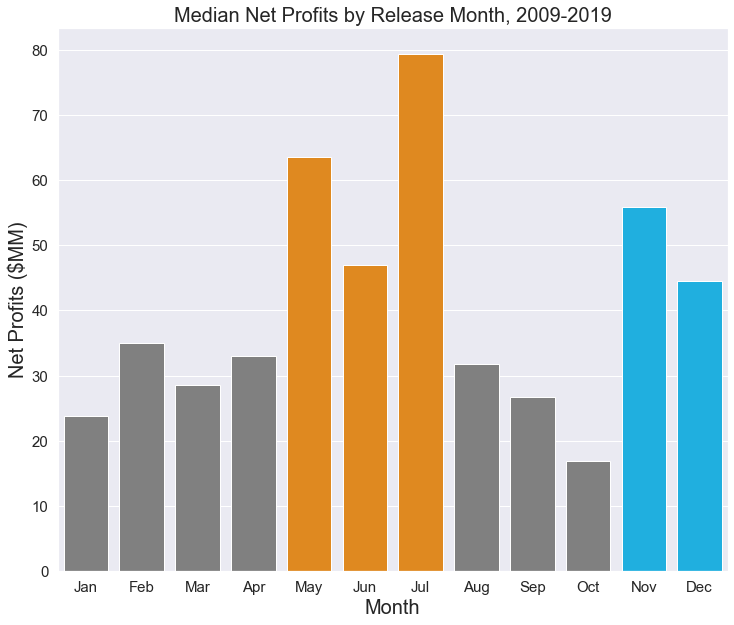

In [20]:
fig, ax = plt.subplots(figsize = (12 , 10))

y = month_medians['net_profits'] / 1000000
ticklabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

cols = ['gray','gray','gray','gray','darkorange','darkorange','darkorange','gray','gray','gray','deepskyblue','deepskyblue']

fig = sns.barplot(data = month_medians,
                  x = 'release_month',
                  y = y,
                  palette=cols)

plt.xlabel('Month', size=20)
ax.set_xticklabels(ticklabels, size=15)
plt.ylabel('Net Profits ($MM)', size=20)
plt.yticks(fontsize=15)
plt.title('Median Net Profits by Release Month, 2009-2019', size=20)
plt.show(fig);

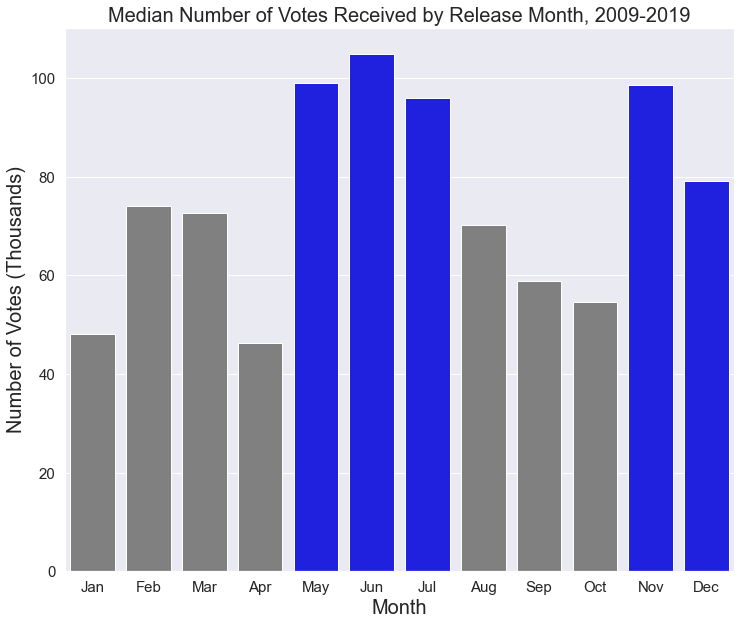

In [22]:
fig, ax = plt.subplots(figsize = (12 , 10))

ticklabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

y = month_medians['numvotes'] / 1000

cols = ['gray' if x < 75000 else 'blue' for x in month_medians['numvotes']]

fig = sns.barplot(data = month_medians,
                  x = 'release_month',
                  y = y,
                  palette = cols)

plt.xlabel('Month', size=20)
ax.set_xticklabels(ticklabels, size=15)
plt.ylabel('Number of Votes (Thousands)', size=20)
plt.yticks(fontsize=15)
plt.title('Median Number of Votes Received by Release Month, 2009-2019', size=20)
plt.show(fig);

In [23]:
top_ratio_all = final_df.sort_values(by='profit_to_budget_ratio', ascending=False).head(10)

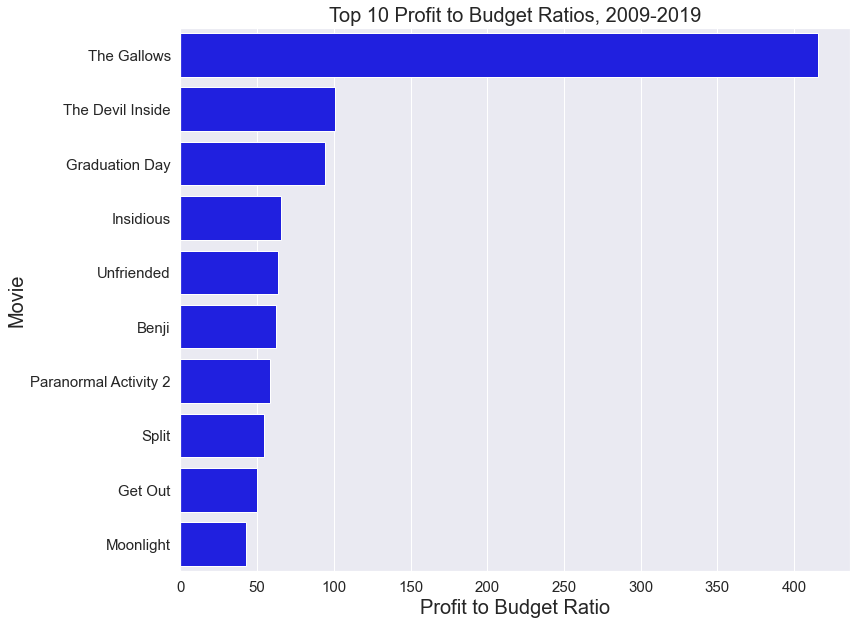

In [24]:
fig, ax = plt.subplots(figsize = (12 , 10))

fig = sns.barplot(data = top_ratio_all,
                  x = 'profit_to_budget_ratio',
                  y = 'movie',
                  color = 'blue',)

plt.xlabel('Profit to Budget Ratio', size=20)
plt.xticks(fontsize=15)
plt.ylabel('Movie', size=20)
plt.yticks(fontsize=15)
plt.title('Top 10 Profit to Budget Ratios, 2009-2019', size=20)
plt.show(fig);

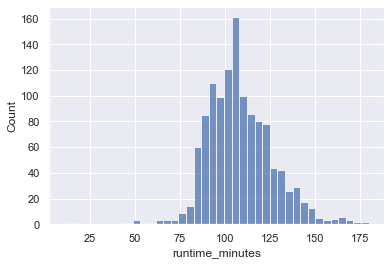

In [109]:
sns.histplot(data=final_df, x='runtime_minutes')
plt.show()

In [111]:
final_df['profit_to_budget_ratio'].describe()

count   1237.00000
mean       3.54345
std       13.40710
min       -0.88831
25%        0.40997
50%        1.60183
75%        3.49948
max      415.56474
Name: profit_to_budget_ratio, dtype: float64

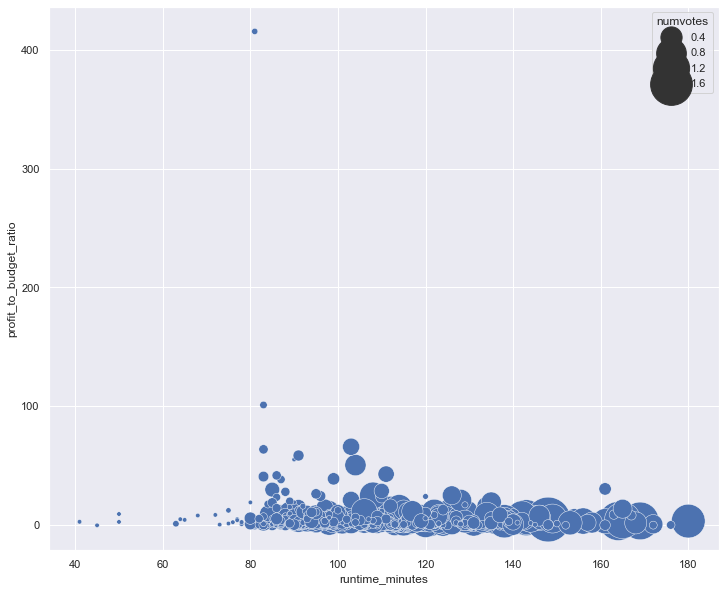

In [119]:
fig, ax = plt.subplots(figsize = (12 , 10))

sns.scatterplot(data=final_df, x="runtime_minutes", y="profit_to_budget_ratio", size="numvotes", sizes=(20, 2000))

plt.show()